## Imported Modules

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")


In [43]:
data = pd.read_csv("recommendation.csv")

In [44]:
data.columns

Index(['Unnamed: 0', 'buy', 'positive_prob', 'day_return', 'week_return',
       'month_return'],
      dtype='object')

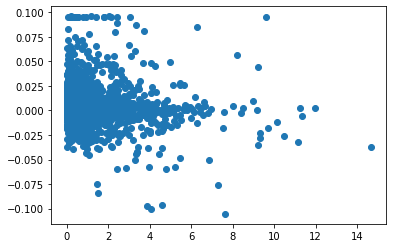

In [45]:
plt.scatter(data['positive_prob'],data['day_return'])
plt.show()

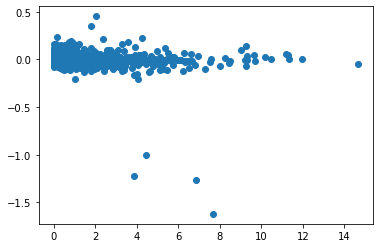

In [46]:
plt.scatter(data['positive_prob'],data['week_return'])
plt.show()

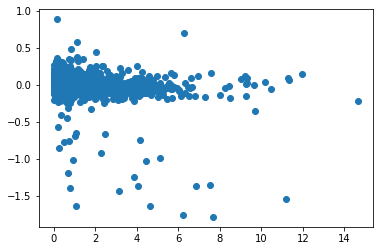

In [47]:
plt.scatter(data['positive_prob'],data['month_return'])
plt.show()

In [48]:
data['daily_direction'] = data['day_return'].apply(lambda x : 1 if x > 0 else 0)
data['weekly_direction'] = data['week_return'].apply(lambda x : 1 if x > 0 else 0)
data['monthly_direction'] = data['month_return'].apply(lambda x : 1 if x > 0 else 0)

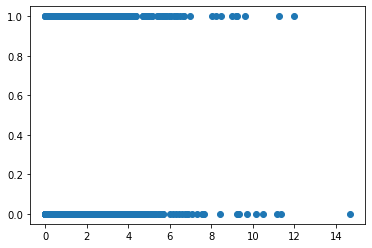

In [49]:
plt.scatter(data['positive_prob'],data['daily_direction'])
plt.show()

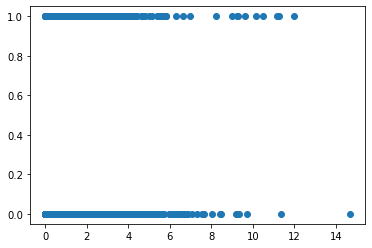

In [50]:
plt.scatter(data['positive_prob'],data['weekly_direction'])
plt.show()

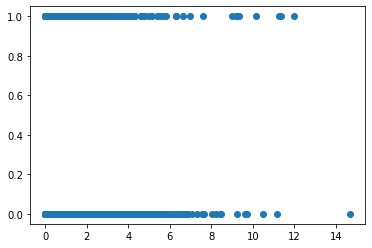

In [51]:
plt.scatter(data['positive_prob'],data['monthly_direction'])
plt.show()

#### Logistic  regression
Actually doing the Logistic Regression is quite simple. Specify the column containing the variable you're trying to predict followed by the columns that the model should use to make the prediction.



In [52]:
import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score


class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [53]:
print(cross_val_score(SMWrapper(sm.OLS), data[predictcol], data['daily_direction'], scoring='r2'))

[-0.06747919 -0.00060417 -0.00098686 -0.00773293 -0.01710419]


Note that it is possible to get a negative R-square for equations that do not contain a constant term. Because R-square is defined as the proportion of variance explained by the fit, if the fit is actually worse than just fitting a horizontal line then R-square is negative.

#### Interpreting the results
Logit also has summary table. 

In [54]:
returnModel.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        daily_direction   No. Observations:                 2743
Model:                          Logit   Df Residuals:                     2742
Method:                           MLE   Df Model:                            0
Date:                Sat, 17 Apr 2021   Pseudo R-squ.:               -0.002855
Time:                        01:38:01   Log-Likelihood:                -1901.1
converged:                       True   LL-Null:                       -1895.7
Covariance Type:            nonrobust   LLR p-value:                       nan
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
positive_prob     0.0132      0.022      0.591      0.554      -0.031       0.057
=================================================================================
"""

You get a great overview of the coefficients of the model, how well those coefficients fit, the overall fit quality, and several other statistical measures.

The result object also lets you to isolate and inspect parts of the model output. The confidence interval gives you an idea for how robust the coefficients of the model are.

In [55]:
returnModel.conf_int(alpha=0.05)

,0,1
positive_prob,-0.030617,0.057055


#### Application of the model

In [56]:
data['Prob']=returnModel.predict(data[predictcol])

In [57]:
data['Label']=[1 if x>0.5 else 0 for x in data['Prob']]

In [58]:
data.head(3)

,Unnamed: 0,buy,positive_prob,day_return,week_return,month_return,daily_direction,weekly_direction,monthly_direction,Prob,Label
0,0,600149.sh,14.6680,-0.037243,-0.049065,-0.220236,0,0,0,0.548323,1
1,1,600228.sh,11.9746,0.002428,0.007267,0.145313,1,1,1,0.539490,1
2,2,002312.sz,11.3559,-0.005455,-0.000907,0.056403,0,0,1,0.537458,1


In [59]:
Predict_table_train=pd.crosstab(data['Label'],data['daily_direction'])

In [60]:
Predict_table_train

daily_direction,0,1
Label,,
1,1284,1459


  ![contingecy table](fig/contingency.jpg)